In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#  Pilgrim Emotion & Stress Heatmap Using AR + AI****

# The goal of this project 

**building a machine learning model that predicts the stress level or frustration risk of a pilgrim based on real-time conditions (crowd, heat, AR performance, etc.). Then we’ll visualize the results in Power BI as a heatmap/dashboard.**

* # Dataset Preparation

In [106]:
#libraries used
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler ,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
df=pd.read_csv('/kaggle/input/hajj-and-umrah-crowd-management-dataset/hajj_umrah_crowd_management_dataset.csv')

In [108]:
df

,Timestamp,Location_Lat,Location_Long,Crowd_Density,Movement_Speed,Activity_Type,Weather_Conditions,Temperature,Sound_Level_dB,AR_System_Interaction,...,Incident_Type,Crowd_Morale,Pilgrim_Experience,Interaction_Frequency,Distance_Between_People_m,Event_Type,Time_Spent_at_Location_minutes,AR_Navigation_Success,Satisfaction_Rating,Perceived_Safety_Rating
0,2024-02-28 05:36:50,21.258846,39.983949,High,0.90,Tawaf,Clear,44,82,Started,...,Theft,Neutral,Experienced,6,0.94,Transport Delay,77,No,2,3
1,2024-07-15 04:07:23,21.353403,39.850382,Low,0.55,Resting,Clear,39,80,Completed,...,Security Breach,Negative,First-Time,8,2.04,Religious Activity,92,No,2,3
2,2024-06-06 08:27:11,21.252375,39.937753,Medium,0.94,Prayer,Clear,32,84,Started,...,Unruly Behavior,Negative,Experienced,2,1.85,Crowd Congestion,16,Yes,5,4
3,2024-12-23 06:29:22,21.377740,39.813333,Medium,0.55,Prayer,Clear,41,79,Started,...,Unruly Behavior,Negative,Experienced,2,0.96,Transport Delay,74,No,3,3
4,2024-08-19 18:00:22,21.360457,39.950974,High,0.36,Sa’i,Rainy,44,67,Completed,...,Theft,Negative,First-Time,10,1.05,Transport Delay,20,No,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2024-01-01 23:57:15,21.209851,39.928508,Low,0.20,Tawaf,Clear,38,72,Started,...,Lost Item,Positive,First-Time,7,2.11,Crowd Congestion,88,Yes,3,2
9996,2024-02-18 19:18:55,21.348037,39.854530,Low,0.41,Walking,Clear,45,86,Started,...,Medical Emergency,Positive,First-Time,0,1.28,Religious Activity,96,Yes,5,3
9997,2024-04-05 04:01:17,21.330442,39.907906,Low,0.45,Tawaf,Rainy,41,75,In Progress,...,Lost Item,Neutral,First-Time,6,2.17,Crowd Congestion,50,No,2,5
9998,2024-04-22 03:49:37,21.209949,39.865282,Low,1.35,Sa’i,Rainy,34,84,Completed,...,Theft,Negative,First-Time,1,0.79,Medical Emergency,33,Yes,4,1


In [109]:
print(df.columns.tolist())

['Timestamp', 'Location_Lat', 'Location_Long', 'Crowd_Density', 'Movement_Speed', 'Activity_Type', 'Weather_Conditions', 'Temperature', 'Sound_Level_dB', 'AR_System_Interaction', 'Fatigue_Level', 'Stress_Level', 'Queue_Time_minutes', 'Health_Condition', 'Age_Group', 'Nationality', 'Transport_Mode', 'Waiting_Time_for_Transport', 'Security_Checkpoint_Wait_Time', 'Emergency_Event', 'Incident_Type', 'Crowd_Morale', 'Pilgrim_Experience', 'Interaction_Frequency', 'Distance_Between_People_m', 'Event_Type', 'Time_Spent_at_Location_minutes', 'AR_Navigation_Success', 'Satisfaction_Rating', 'Perceived_Safety_Rating']


In [110]:
df1=df[["Crowd_Density",
    "Sound_Level_dB",
    "Movement_Speed",
    "Temperature",
    "Weather_Conditions",
    "Time_Spent_at_Location_minutes",
    
    "AR_System_Interaction",
    "AR_Navigation_Success",
    "Interaction_Frequency",

    "Age_Group",
    "Pilgrim_Experience",

    "Event_Type",
    "Distance_Between_People_m",
    "Location_Lat", "Location_Long",
    

    "Fatigue_Level", "Stress_Level"]]

**splitting the features into 4 categores**
1. Environment & crowd context [crowd density, sound level ,movment speed, tempterture , weather condition , time spent at location minutes]
2. Behavioral signals from AR + interaction [AR system interaction AR navigation success , interaction frequency]
3. Demographics [age group , pilgrim experience ]
4. Stress-related context [Event Type ,Distance_Between_People_m, Location_Lat, Location_Long]

In [111]:
# Select the desired input features (independent variables)
selected_features = [
    # Environment & crowd context
    "Crowd_Density",
    "Sound_Level_dB",
    "Movement_Speed",
    "Temperature",
    "Weather_Conditions",
    "Time_Spent_at_Location_minutes",
    
    # Behavioral signals from AR + interaction
    "AR_System_Interaction",         # This might be a richer source than just AR_Navigation_Success
    "AR_Navigation_Success",
    "Interaction_Frequency",

    # Demographics
    "Age_Group",
    "Pilgrim_Experience",

    # Stress-related context
    "Event_Type",                    # Certain events might cause more stress
    "Distance_Between_People_m",     # Closer crowding = more stress
    "Location_Lat", "Location_Long"  # For mapping location-wise emotion risk
]

In [112]:
# Extract features (X) from the dataset
X = df1[selected_features]

# Display the first few rows of X
X.head()

,Crowd_Density,Sound_Level_dB,Movement_Speed,Temperature,Weather_Conditions,Time_Spent_at_Location_minutes,AR_System_Interaction,AR_Navigation_Success,Interaction_Frequency,Age_Group,Pilgrim_Experience,Event_Type,Distance_Between_People_m,Location_Lat,Location_Long
0,High,82,0.90,44,Clear,77,Started,No,6,70+,Experienced,Transport Delay,0.94,21.258846,39.983949
1,Low,80,0.55,39,Clear,92,Completed,No,8,18-30,First-Time,Religious Activity,2.04,21.353403,39.850382
2,Medium,84,0.94,32,Clear,16,Started,Yes,2,18-30,Experienced,Crowd Congestion,1.85,21.252375,39.937753
3,Medium,79,0.55,41,Clear,74,Started,No,2,18-30,Experienced,Transport Delay,0.96,21.377740,39.813333
4,High,67,0.36,44,Rainy,20,Completed,No,10,51-70,First-Time,Transport Delay,1.05,21.360457,39.950974


**Target Variables (Labels)**
**These are the outputs you want your model to predict:**

1. Fatigue_Level

1. Stress_Level

In [113]:
target_variables = ["Fatigue_Level", "Stress_Level"]
y = df1[target_variables]
y.head()

,Fatigue_Level,Stress_Level
0,Medium,High
1,High,Medium
2,High,High
3,Low,Medium
4,Low,Low


# Preproccessing data

**1. Environment & crowd context:**

**features name**
* crowd density, 
* sound level ,
* movment speed,
* tempterture ,
* weather condition ,
* time spent at location minutes

### Preprocessing Environment and Crowd Data

We extracted a subset of the data relevant to environmental and crowd conditions. Then we performed the following preprocessing steps:

- **Null Check:** Verified there are no missing values.
- **Data Types:** Confirmed categorical vs numerical features.
- **One-Hot Encoding:** Applied to categorical columns `Crowd_Density` and `Weather_Conditions`.
- **Normalization:** Applied Min-Max Scaling to numerical columns to bring all values to a similar scale between 0 and 1.

This preprocessing prepares the data for downstream machine learning models or clustering.

In [114]:
environment_crowd= X[["Crowd_Density","Sound_Level_dB","Movement_Speed","Temperature","Weather_Conditions","Time_Spent_at_Location_minutes"]]

environment_crowd

,Crowd_Density,Sound_Level_dB,Movement_Speed,Temperature,Weather_Conditions,Time_Spent_at_Location_minutes
0,High,82,0.90,44,Clear,77
1,Low,80,0.55,39,Clear,92
2,Medium,84,0.94,32,Clear,16
3,Medium,79,0.55,41,Clear,74
4,High,67,0.36,44,Rainy,20
...,...,...,...,...,...,...
9995,Low,72,0.20,38,Clear,88
9996,Low,86,0.41,45,Clear,96
9997,Low,75,0.45,41,Rainy,50
9998,Low,84,1.35,34,Rainy,33


In [115]:
# Check for null values
null_counts = environment_crowd.isnull().sum()

# Check data types
data_types = environment_crowd.dtypes

print("Null Values:\n", null_counts)
print("\nData Types:\n", data_types)


Null Values:
 Crowd_Density                     0
Sound_Level_dB                    0
Movement_Speed                    0
Temperature                       0
Weather_Conditions                0
Time_Spent_at_Location_minutes    0
dtype: int64

Data Types:
 Crowd_Density                      object
Sound_Level_dB                      int64
Movement_Speed                    float64
Temperature                         int64
Weather_Conditions                 object
Time_Spent_at_Location_minutes      int64
dtype: object


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

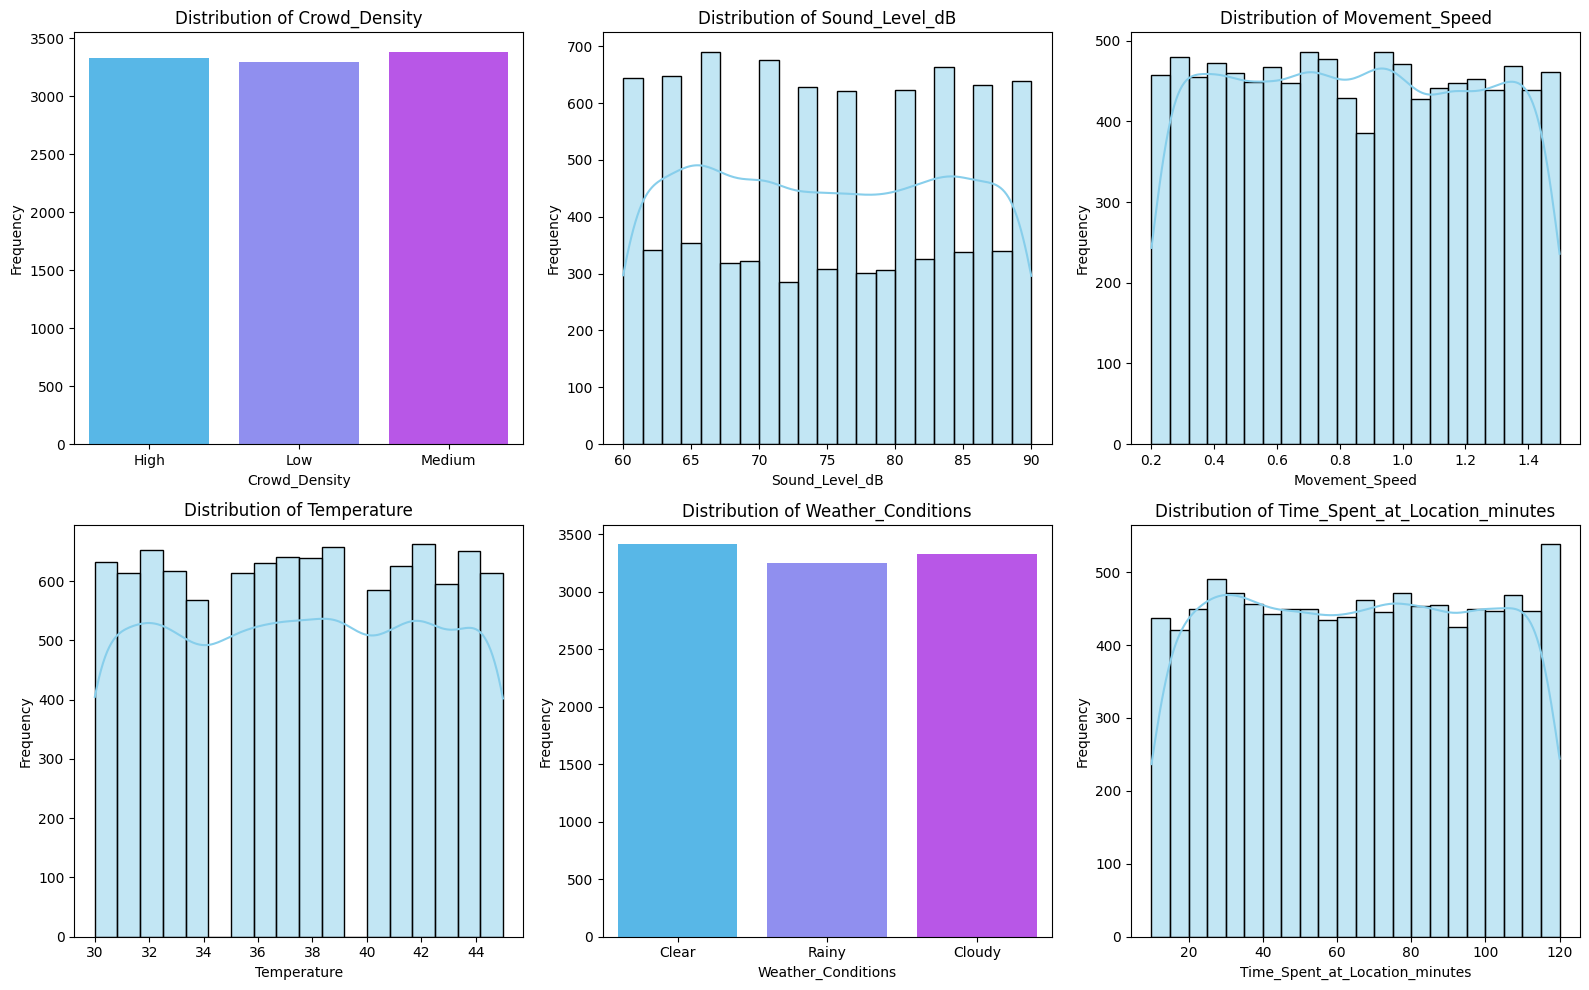

In [116]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(environment_crowd):
    plt.subplot(2, 3, i+1)
    if df1[col].dtype == "object":
        sns.countplot(x=col, data=df1, palette="cool")
    else:
        sns.histplot(df1[col], kde=True, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [117]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Define categorical and numerical features
categorical_features = ['Crowd_Density', 'Weather_Conditions']
numerical_features = ['Sound_Level_dB', 'Movement_Speed', 'Temperature', 'Time_Spent_at_Location_minutes']

# One-Hot Encoding for categorical, passthrough numerical
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# Fit and transform
X_processed = preprocessor.fit_transform(environment_crowd)

# Get encoded feature names
encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_column_names = numerical_features + list(encoded_cat_names)

# Convert to DataFrame
X_final = pd.DataFrame(X_processed, columns=all_column_names)

# Display the first few rows
X_final.head()


,Sound_Level_dB,Movement_Speed,Temperature,Time_Spent_at_Location_minutes,Crowd_Density_High,Crowd_Density_Low,Crowd_Density_Medium,Weather_Conditions_Clear,Weather_Conditions_Cloudy,Weather_Conditions_Rainy
0,82.0,0.90,44.0,77.0,1.0,0.0,0.0,1.0,0.0,0.0
1,80.0,0.55,39.0,92.0,0.0,1.0,0.0,1.0,0.0,0.0
2,84.0,0.94,32.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0
3,79.0,0.55,41.0,74.0,0.0,0.0,1.0,1.0,0.0,0.0
4,67.0,0.36,44.0,20.0,1.0,0.0,0.0,0.0,0.0,1.0


**2. Behavioral signals from AR + interaction :**

**features name:**
* AR system interaction
* AR navigation success
* interaction frequency

In [118]:
Behavioral_AR_interaction = X[["AR_System_Interaction","AR_Navigation_Success","Interaction_Frequency"]]

In [119]:
print(Behavioral_AR_interaction.isnull().sum())
print(Behavioral_AR_interaction.dtypes)

AR_System_Interaction    0
AR_Navigation_Success    0
Interaction_Frequency    0
dtype: int64
AR_System_Interaction    object
AR_Navigation_Success    object
Interaction_Frequency     int64
dtype: object


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


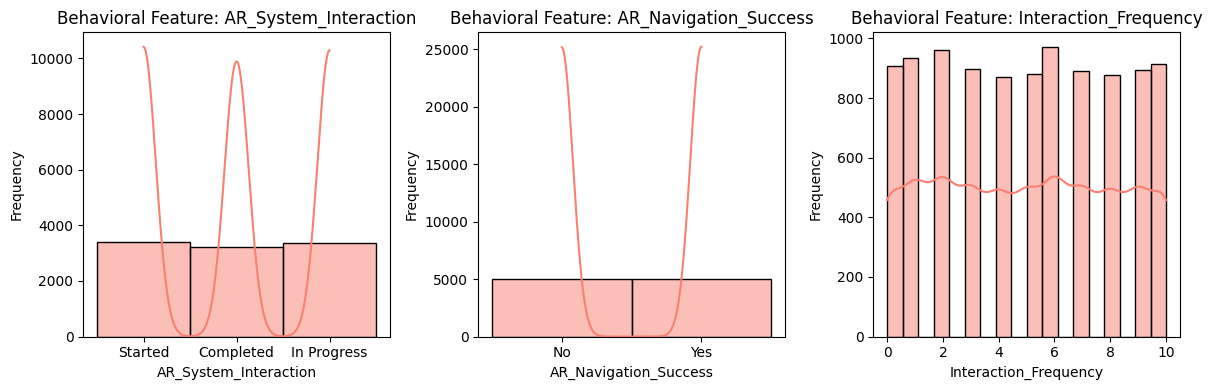

In [120]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(Behavioral_AR_interaction):
    plt.subplot(1, 3, i+1)
    sns.histplot(df1[col], kde=True, color="salmon")
    plt.title(f"Behavioral Feature: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [121]:
# Define the categorical and numerical columns
behavioral_cat = ['AR_System_Interaction', 'AR_Navigation_Success']
behavioral_num = ['Interaction_Frequency']

# Create the column transformer
behavioral_preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', behavioral_num),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), behavioral_cat)
])

# Fit and transform the data
behavioral_processed = behavioral_preprocessor.fit_transform(Behavioral_AR_interaction)

# Get new column names
behavioral_cat_names = behavioral_preprocessor.named_transformers_['cat'].get_feature_names_out(behavioral_cat)
behavioral_col_names = behavioral_num + list(behavioral_cat_names)

# Convert to DataFrame
behavioral_df = pd.DataFrame(behavioral_processed, columns=behavioral_col_names)

In [122]:
# Concatenate the new features to the previously processed features
X_final = pd.concat([X_final.reset_index(drop=True), behavioral_df.reset_index(drop=True)], axis=1)

# Show the updated X_final
X_final.head()

,Sound_Level_dB,Movement_Speed,Temperature,Time_Spent_at_Location_minutes,Crowd_Density_High,Crowd_Density_Low,Crowd_Density_Medium,Weather_Conditions_Clear,Weather_Conditions_Cloudy,Weather_Conditions_Rainy,Interaction_Frequency,AR_System_Interaction_Completed,AR_System_Interaction_In Progress,AR_System_Interaction_Started,AR_Navigation_Success_No,AR_Navigation_Success_Yes
0,82.0,0.90,44.0,77.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,0.0
1,80.0,0.55,39.0,92.0,0.0,1.0,0.0,1.0,0.0,0.0,8.0,1.0,0.0,0.0,1.0,0.0
2,84.0,0.94,32.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0
3,79.0,0.55,41.0,74.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0
4,67.0,0.36,44.0,20.0,1.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,0.0,0.0,1.0,0.0


**3.Demographics:** 

**features name**
* age group
* pilgrim experience

In [123]:
demographic_features = X[["Age_Group", "Pilgrim_Experience"]]

In [124]:
print(demographic_features.isnull().sum())
print(demographic_features.dtypes)

Age_Group             0
Pilgrim_Experience    0
dtype: int64
Age_Group             object
Pilgrim_Experience    object
dtype: object


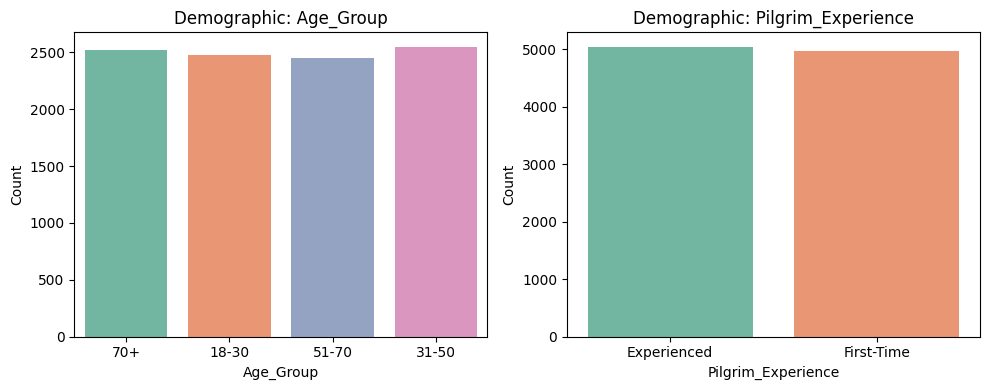

In [125]:
plt.figure(figsize=(10, 4))
for i, col in enumerate(demographic_features):
    plt.subplot(1, 2, i+1)
    sns.countplot(x=col, data=df1, palette="Set2")
    plt.title(f"Demographic: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [126]:
# All are categorical, so we can directly one-hot encode them
demographic_preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ["Age_Group", "Pilgrim_Experience"])
])

# Fit and transform
demographic_processed = demographic_preprocessor.fit_transform(demographic_features)

# Get feature names
demographic_col_names = demographic_preprocessor.named_transformers_['cat'].get_feature_names_out(["Age_Group", "Pilgrim_Experience"])

# Convert to DataFrame
demographic_df = pd.DataFrame(demographic_processed, columns=demographic_col_names)

In [127]:
# Concatenate with X_final
X_final = pd.concat([X_final.reset_index(drop=True), demographic_df.reset_index(drop=True)], axis=1)

# View the final DataFrame
X_final.head()

,Sound_Level_dB,Movement_Speed,Temperature,Time_Spent_at_Location_minutes,Crowd_Density_High,Crowd_Density_Low,Crowd_Density_Medium,Weather_Conditions_Clear,Weather_Conditions_Cloudy,Weather_Conditions_Rainy,...,AR_System_Interaction_In Progress,AR_System_Interaction_Started,AR_Navigation_Success_No,AR_Navigation_Success_Yes,Age_Group_18-30,Age_Group_31-50,Age_Group_51-70,Age_Group_70+,Pilgrim_Experience_Experienced,Pilgrim_Experience_First-Time
0,82.0,0.90,44.0,77.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,80.0,0.55,39.0,92.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,84.0,0.94,32.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,79.0,0.55,41.0,74.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,67.0,0.36,44.0,20.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


**4.Stress-related context:**

**features name**
* Event_Type
* Distance_Between_People_m
* Location_Lat
* Location_Long

In [128]:
stress_features = X[["Event_Type", "Distance_Between_People_m", "Location_Lat", "Location_Long"]]

In [129]:
print(stress_features.isnull().sum())
print(stress_features.dtypes)


Event_Type                   0
Distance_Between_People_m    0
Location_Lat                 0
Location_Long                0
dtype: int64
Event_Type                    object
Distance_Between_People_m    float64
Location_Lat                 float64
Location_Long                float64
dtype: object


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


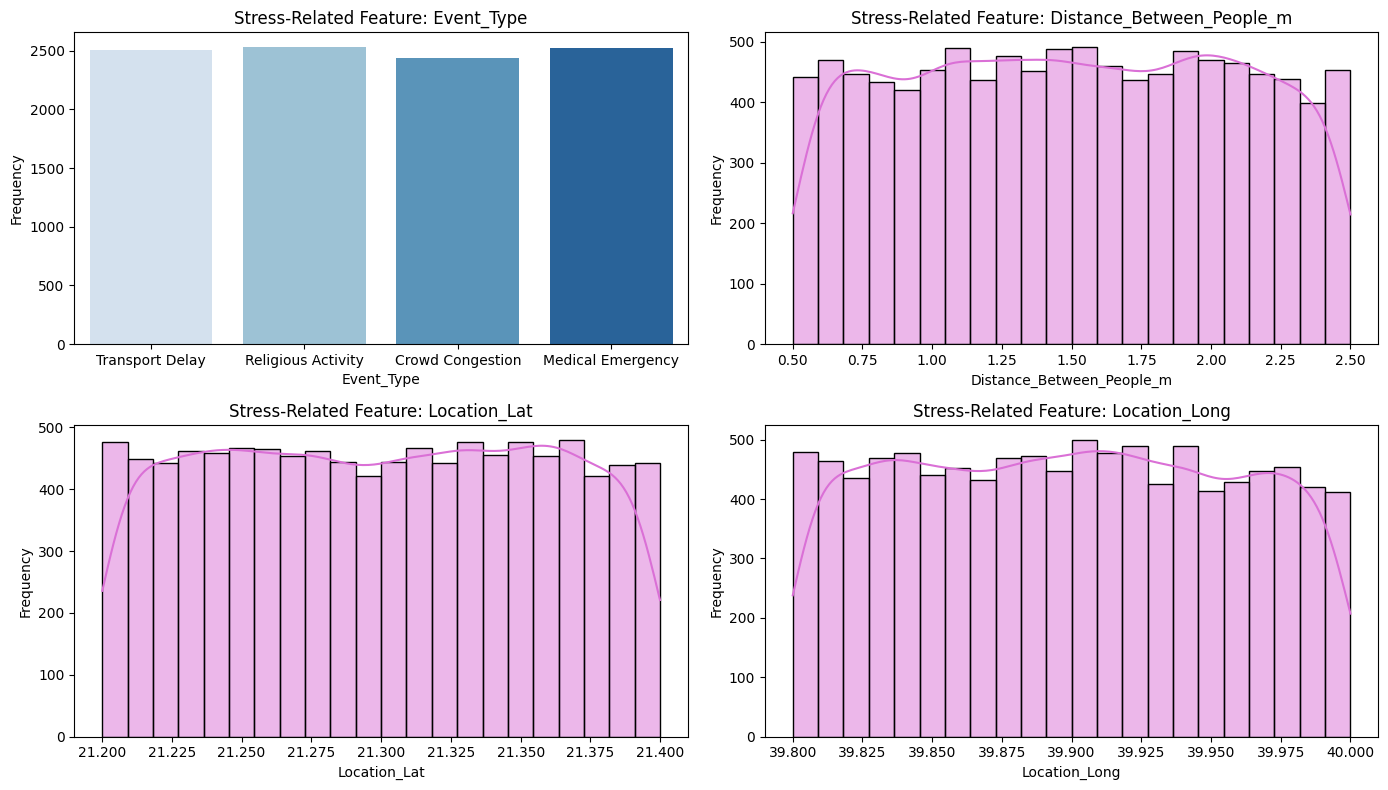

In [130]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(stress_features):
    plt.subplot(2, 2, i+1)
    if df1[col].dtype == "object":
        sns.countplot(x=col, data=df1, palette="Blues")
    else:
        sns.histplot(df1[col], kde=True, color="orchid")
    plt.title(f"Stress-Related Feature: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [131]:
stress_cat_cols = ["Event_Type"]
stress_num_cols = ["Distance_Between_People_m", "Location_Lat", "Location_Long"]

In [132]:
stress_preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), stress_cat_cols),
    ('num', 'passthrough', stress_num_cols)
])
stress_processed = stress_preprocessor.fit_transform(stress_features)

cat_names = stress_preprocessor.named_transformers_['cat'].get_feature_names_out(stress_cat_cols)
num_names = stress_num_cols
stress_col_names = np.concatenate([cat_names, num_names])
stress_df = pd.DataFrame(stress_processed, columns=stress_col_names)


In [133]:
X_final = pd.concat([X_final.reset_index(drop=True), stress_df.reset_index(drop=True)], axis=1)
X_final

,Sound_Level_dB,Movement_Speed,Temperature,Time_Spent_at_Location_minutes,Crowd_Density_High,Crowd_Density_Low,Crowd_Density_Medium,Weather_Conditions_Clear,Weather_Conditions_Cloudy,Weather_Conditions_Rainy,...,Age_Group_70+,Pilgrim_Experience_Experienced,Pilgrim_Experience_First-Time,Event_Type_Crowd Congestion,Event_Type_Medical Emergency,Event_Type_Religious Activity,Event_Type_Transport Delay,Distance_Between_People_m,Location_Lat,Location_Long
0,82.0,0.90,44.0,77.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.94,21.258846,39.983949
1,80.0,0.55,39.0,92.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.04,21.353403,39.850382
2,84.0,0.94,32.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.85,21.252375,39.937753
3,79.0,0.55,41.0,74.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.96,21.377740,39.813333
4,67.0,0.36,44.0,20.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.05,21.360457,39.950974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,72.0,0.20,38.0,88.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.11,21.209851,39.928508
9996,86.0,0.41,45.0,96.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.28,21.348037,39.854530
9997,75.0,0.45,41.0,50.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.17,21.330442,39.907906
9998,84.0,1.35,34.0,33.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.79,21.209949,39.865282


# Preprocessing the Target Lable

In [134]:
y

,Fatigue_Level,Stress_Level
0,Medium,High
1,High,Medium
2,High,High
3,Low,Medium
4,Low,Low
...,...,...
9995,Low,High
9996,High,Medium
9997,Low,High
9998,Medium,Medium


In [135]:
print(y.isnull().sum())
print(y.dtypes)

Fatigue_Level    0
Stress_Level     0
dtype: int64
Fatigue_Level    object
Stress_Level     object
dtype: object


In [136]:
# Copy the original labels
y_encoded = y.copy()

# Apply LabelEncoder to each target variable
label_encoders = {}
for col in y.columns:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(y[col])
    label_encoders[col] = le  # Save the encoder in case you want to inverse transform later

In [137]:
y_encoded.head()

,Fatigue_Level,Stress_Level
0,2,0
1,0,2
2,0,0
3,1,2
4,1,1


**check if the data is balanced, and showing the distribution of class labels in each target variable — Fatigue_Level and Stress_Level.**

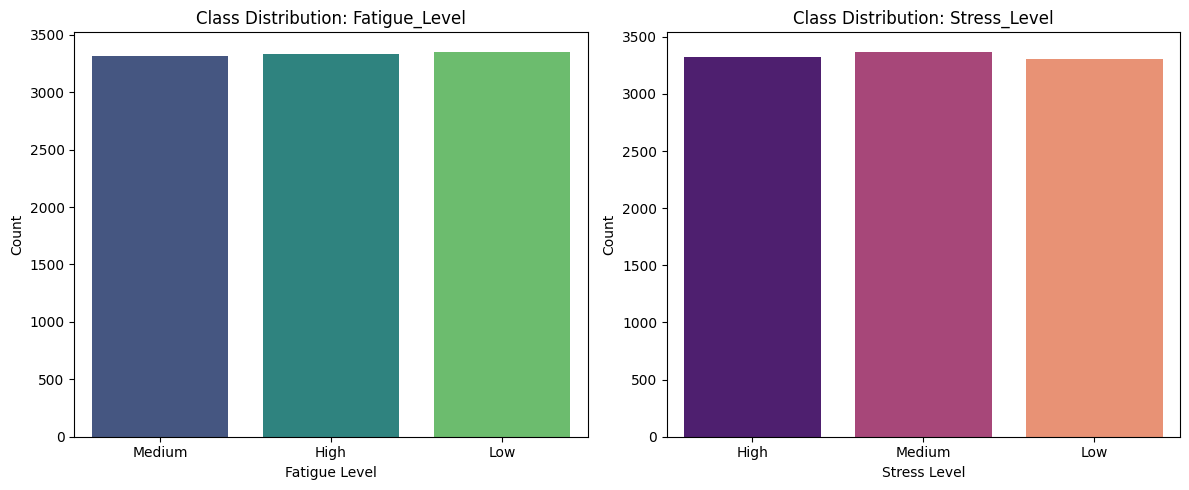

In [138]:
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot for Fatigue_Level
plt.subplot(1, 2, 1)
sns.countplot(x='Fatigue_Level', data=y, palette='viridis')
plt.title('Class Distribution: Fatigue_Level')
plt.xlabel('Fatigue Level')
plt.ylabel('Count')

# Plot for Stress_Level
plt.subplot(1, 2, 2)
sns.countplot(x='Stress_Level', data=y, palette='magma')
plt.title('Class Distribution: Stress_Level')
plt.xlabel('Stress Level')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

i will choose the fatigue level becouse it's more balanced 

In [139]:
# Combine features and targets into one DataFrame
data_combined = pd.concat([X_final, y_encoded], axis=1)

# Create a combined label from both target columns
data_combined['combined_label'] =  data_combined['Fatigue_Level'].astype(str)

# Find the smallest class count for the combined label
min_class_count = data_combined['combined_label'].value_counts().min()

# Undersample each combination class
balanced_df = data_combined.groupby('combined_label').apply(lambda x: x.sample(min_class_count, random_state=42)).reset_index(drop=True)

# Separate features and targets again
X_resampled = balanced_df.drop(columns=y_encoded.columns.tolist() + ['combined_label'])
y_resampled = balanced_df[y_encoded.columns]

# ✅ Optional: Show the balanced counts of the combined classes
print(balanced_df['combined_label'].value_counts())


combined_label
0    3316
1    3316
2    3316
Name: count, dtype: int64


/tmp/ipykernel_35/3492608581.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = data_combined.groupby('combined_label').apply(lambda x: x.sample(min_class_count, random_state=42)).reset_index(drop=True)


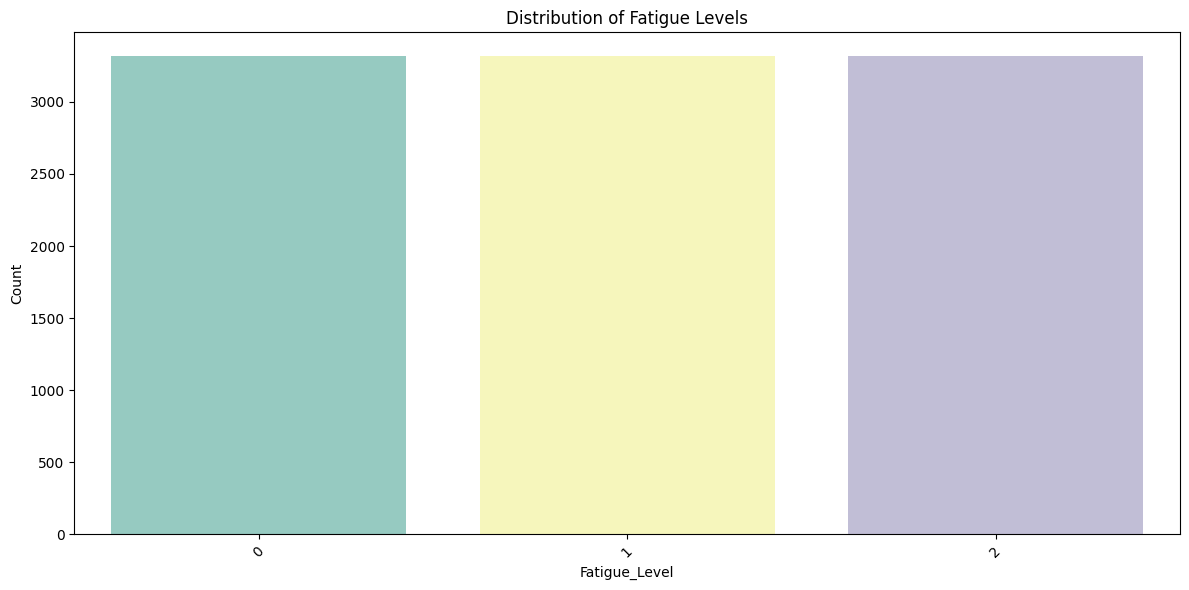

In [140]:
# Plot the combined label distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='combined_label', data=balanced_df, palette='Set3')

plt.title('Distribution of Fatigue Levels')
plt.xlabel('Fatigue_Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

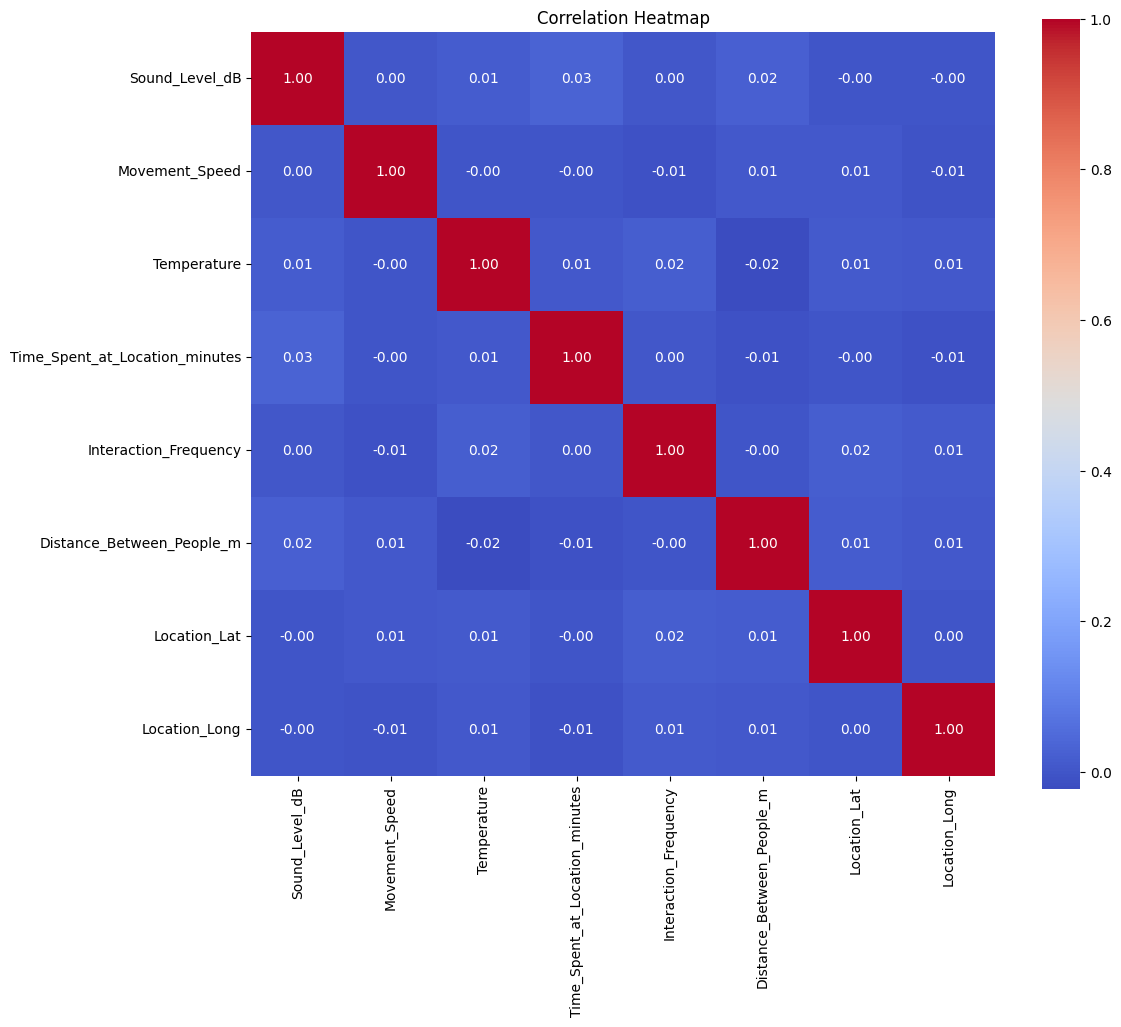

In [141]:
# Correlation matrix (for numerical features only)
numeric_df = df1.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [142]:
data_combined

,Sound_Level_dB,Movement_Speed,Temperature,Time_Spent_at_Location_minutes,Crowd_Density_High,Crowd_Density_Low,Crowd_Density_Medium,Weather_Conditions_Clear,Weather_Conditions_Cloudy,Weather_Conditions_Rainy,...,Event_Type_Crowd Congestion,Event_Type_Medical Emergency,Event_Type_Religious Activity,Event_Type_Transport Delay,Distance_Between_People_m,Location_Lat,Location_Long,Fatigue_Level,Stress_Level,combined_label
0,82.0,0.90,44.0,77.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.94,21.258846,39.983949,2,0,2
1,80.0,0.55,39.0,92.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.04,21.353403,39.850382,0,2,0
2,84.0,0.94,32.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.85,21.252375,39.937753,0,0,0
3,79.0,0.55,41.0,74.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.96,21.377740,39.813333,1,2,1
4,67.0,0.36,44.0,20.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.05,21.360457,39.950974,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,72.0,0.20,38.0,88.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.11,21.209851,39.928508,1,0,1
9996,86.0,0.41,45.0,96.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.28,21.348037,39.854530,0,2,0
9997,75.0,0.45,41.0,50.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,2.17,21.330442,39.907906,1,0,1
9998,84.0,1.35,34.0,33.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.79,21.209949,39.865282,2,2,2


In [143]:
df = data_combined.drop(columns=['combined_label', 'Stress_Level'])

In [144]:
df

,Sound_Level_dB,Movement_Speed,Temperature,Time_Spent_at_Location_minutes,Crowd_Density_High,Crowd_Density_Low,Crowd_Density_Medium,Weather_Conditions_Clear,Weather_Conditions_Cloudy,Weather_Conditions_Rainy,...,Pilgrim_Experience_Experienced,Pilgrim_Experience_First-Time,Event_Type_Crowd Congestion,Event_Type_Medical Emergency,Event_Type_Religious Activity,Event_Type_Transport Delay,Distance_Between_People_m,Location_Lat,Location_Long,Fatigue_Level
0,82.0,0.90,44.0,77.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.94,21.258846,39.983949,2
1,80.0,0.55,39.0,92.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.04,21.353403,39.850382,0
2,84.0,0.94,32.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.85,21.252375,39.937753,0
3,79.0,0.55,41.0,74.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.96,21.377740,39.813333,1
4,67.0,0.36,44.0,20.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.05,21.360457,39.950974,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,72.0,0.20,38.0,88.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.11,21.209851,39.928508,1
9996,86.0,0.41,45.0,96.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.28,21.348037,39.854530,0
9997,75.0,0.45,41.0,50.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.17,21.330442,39.907906,1
9998,84.0,1.35,34.0,33.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.79,21.209949,39.865282,2


In [145]:
df.dtypes

Sound_Level_dB                       float64
Movement_Speed                       float64
Temperature                          float64
Time_Spent_at_Location_minutes       float64
Crowd_Density_High                   float64
Crowd_Density_Low                    float64
Crowd_Density_Medium                 float64
Weather_Conditions_Clear             float64
Weather_Conditions_Cloudy            float64
Weather_Conditions_Rainy             float64
Interaction_Frequency                float64
AR_System_Interaction_Completed      float64
AR_System_Interaction_In Progress    float64
AR_System_Interaction_Started        float64
AR_Navigation_Success_No             float64
AR_Navigation_Success_Yes            float64
Age_Group_18-30                      float64
Age_Group_31-50                      float64
Age_Group_51-70                      float64
Age_Group_70+                        float64
Pilgrim_Experience_Experienced       float64
Pilgrim_Experience_First-Time        float64
Event_Type

# Splitting the dataset into the features and labels

In [178]:
from sklearn.utils import resample
import pandas as pd

# Separate features and target
X = df.drop(columns=['Fatigue_Level'])
y = df['Fatigue_Level']

# Combine for easier processing
df = pd.concat([X, y], axis=1)

# Separate each class
df_0 = df[df['Fatigue_Level'] == 0]
df_1 = df[df['Fatigue_Level'] == 1]
df_2 = df[df['Fatigue_Level'] == 2]

# Find the minimum class size
min_size = min(len(df_0), len(df_1), len(df_2))

# Downsample all classes to match the smallest one
df_0_down = resample(df_0, replace=False, n_samples=min_size, random_state=42)
df_1_down = resample(df_1, replace=False, n_samples=min_size, random_state=42)
df_2_down = resample(df_2, replace=False, n_samples=min_size, random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_0_down, df_1_down, df_2_down])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate again into X and y
X_balanced = df_balanced.drop(columns=['Fatigue_Level'])
y_balanced = df_balanced['Fatigue_Level']

In [179]:
from sklearn.model_selection import train_test_split

#splitting into traing and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       679
           1       1.00      1.00      1.00       643
           2       1.00      1.00      1.00       678

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [181]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y, cv=5, scoring='f1_macro')
print("Cross-validated F1 scores:", scores)
print("Mean F1:", scores.mean())


Cross-validated F1 scores: [1. 1. 1. 1. 1.]
Mean F1: 1.0


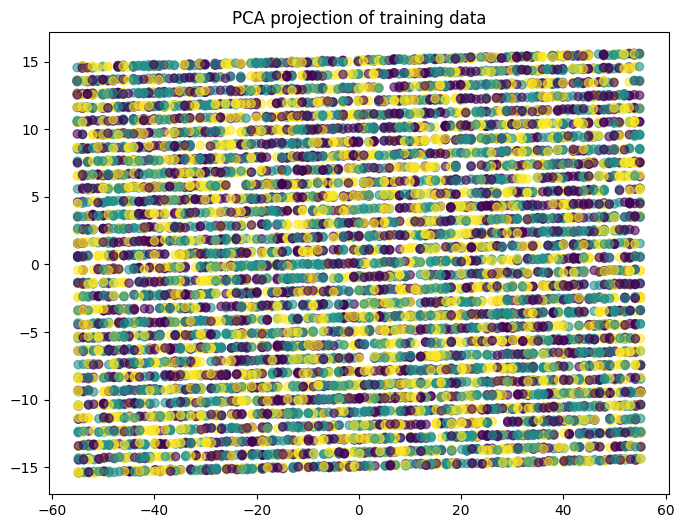

In [182]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title("PCA projection of training data")
plt.show()


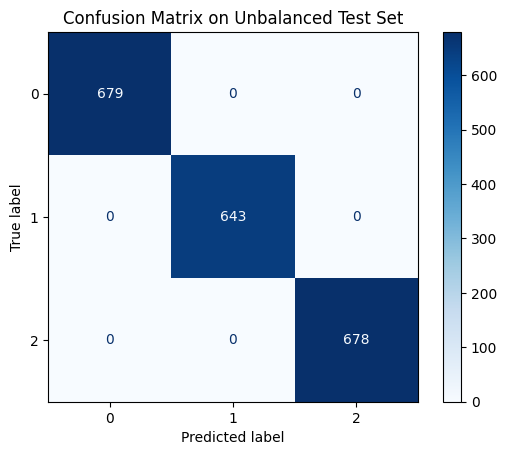

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fit the model on the balanced training data
model = RandomForestClassifier(random_state=42)
model.fit(X_balanced, y_balanced)

# Predict on the original (unbalanced) test set
y_pred = model.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Unbalanced Test Set")
plt.show()


In [184]:
from sklearn.metrics import classification_report

print("Classification Report on Unbalanced Test Set:")
print(classification_report(y_test, y_pred))

Classification Report on Unbalanced Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       679
           1       1.00      1.00      1.00       643
           2       1.00      1.00      1.00       678

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

